# Test validity step 2 : $P(s_c | ...) \propto (s_c - s_{c,WF})^t (C^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) (s_c - s_{c,WF})$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist
import lineax as lx

import micmac as micmac

In [2]:
PRNGKey = random.PRNGKey(0)


In [3]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [4]:
instrument

frequency  depth_p  depth_i  fwhm  f_sky    status  \
0       27.0     49.5     35.0  91.0    0.1  forecast   
1       39.0     29.7     21.0  63.0    0.1  forecast   
2       93.0      3.7      2.6  30.0    0.1  forecast   
3      145.0      4.7      3.3  17.0    0.1  forecast   
4      225.0      8.9      6.3  11.0    0.1  forecast   
5      280.0     22.6     16.0   9.0    0.1  forecast   

                                           reference    type  \
0  Journal of Cosmology and Astroparticle Physics...  ground   
1  Journal of Cosmology and Astroparticle Physics...  ground   
2  Journal of Cosmology and Astroparticle Physics...  ground   
3  Journal of Cosmology and Astroparticle Physics...  ground   
4  Journal of Cosmology and Astroparticle Physics...  ground   
5  Journal of Cosmology and Astroparticle Physics...  ground   

                                  note experiment  
0  depth_p is simply depth_i * sqrt(2)     SO_SAT  
1  depth_p is simply depth_i * sqrt(2)     SO_SAT  
2  depth_p is simply depth_i * sqrt(2)     SO_SAT  
3  depth_p is simply depth_i * sqrt(2)     SO_SAT  
4  depth_p is simply depth_i * sqrt(2)     SO_SAT  
5  depth_p is simply depth_i * sqrt(2)     SO_SAT

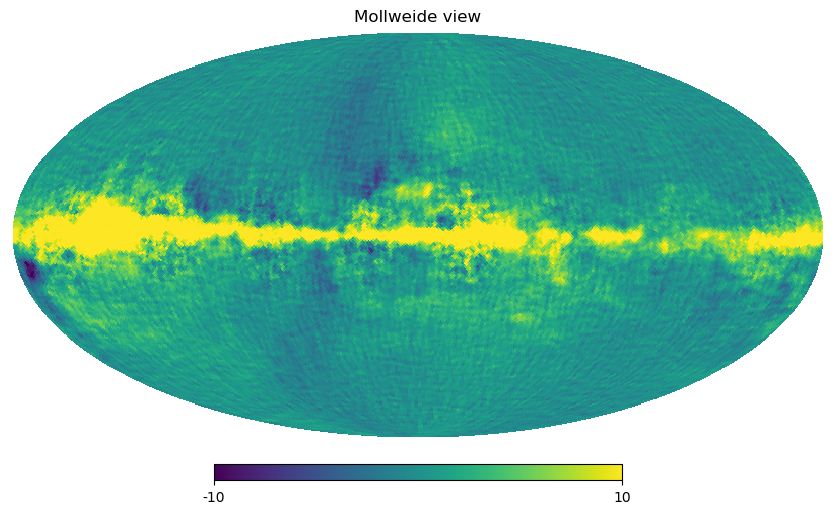

In [5]:
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, n_pix

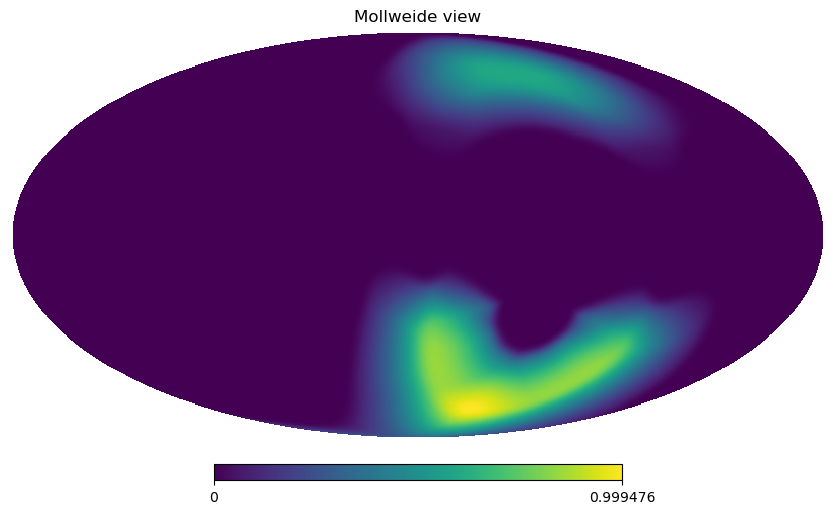

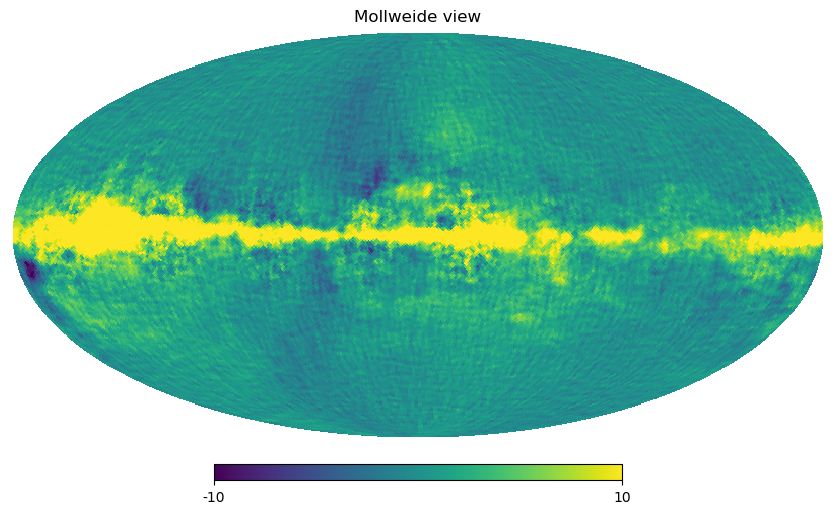

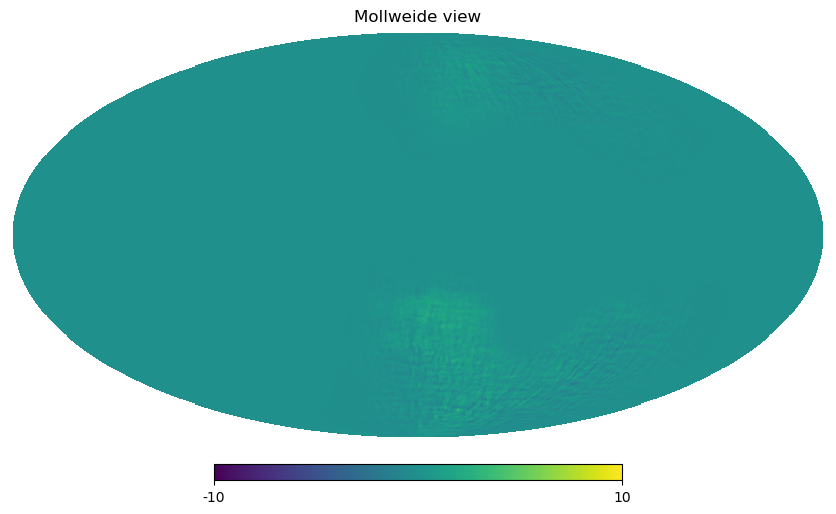

In [6]:
path_mask_test = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask_test = hp.read_map(path_mask_test)
hp.mollview(mask_test)
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, n_pixhp.mollview(freq_maps[0,0]) # Freq, nstokes, n_pix
hp.mollview(freq_maps[2,0]*hp.ud_grade(mask_test,nside_out=64), min=-10, max=10) # Freq, nstokes, n_pix

In [7]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_full_chain_v1d.toml'
# path_toml_file = directory_toml_file + 'corr_full_chain_v3a.toml'
# path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'biased_full_chain_v1b.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1cc.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1cd.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1d.toml'


In [8]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [9]:
reduction_noise = 1

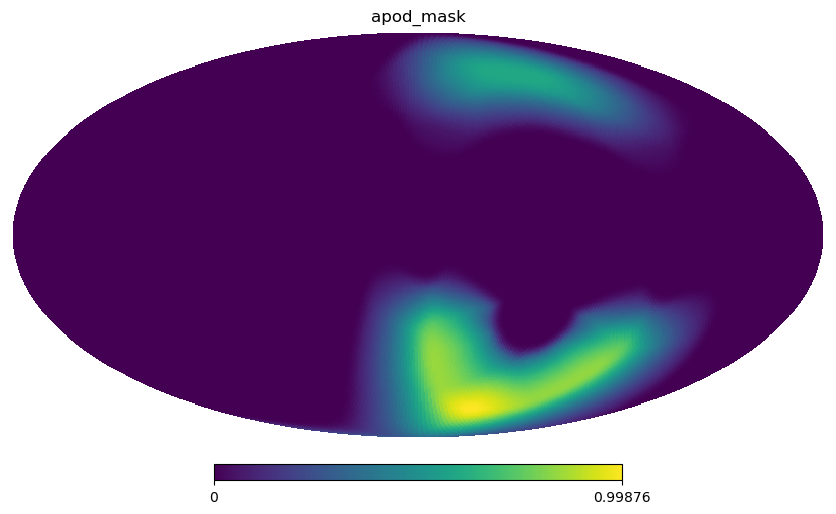

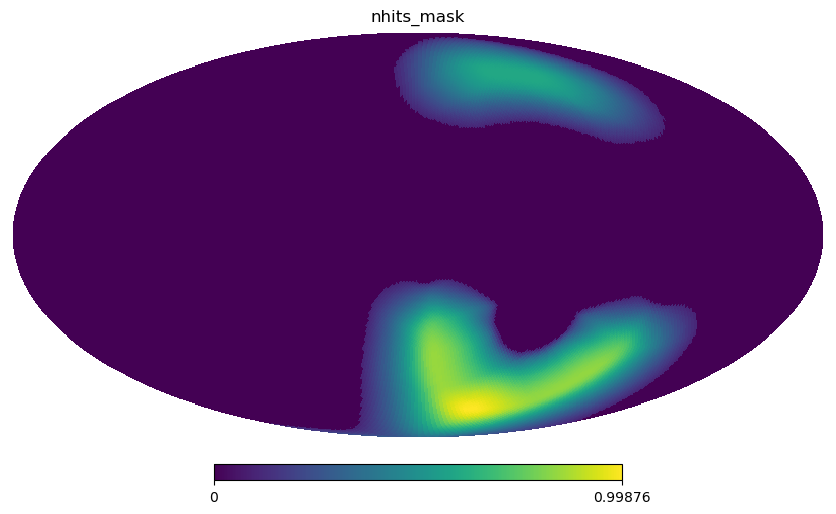

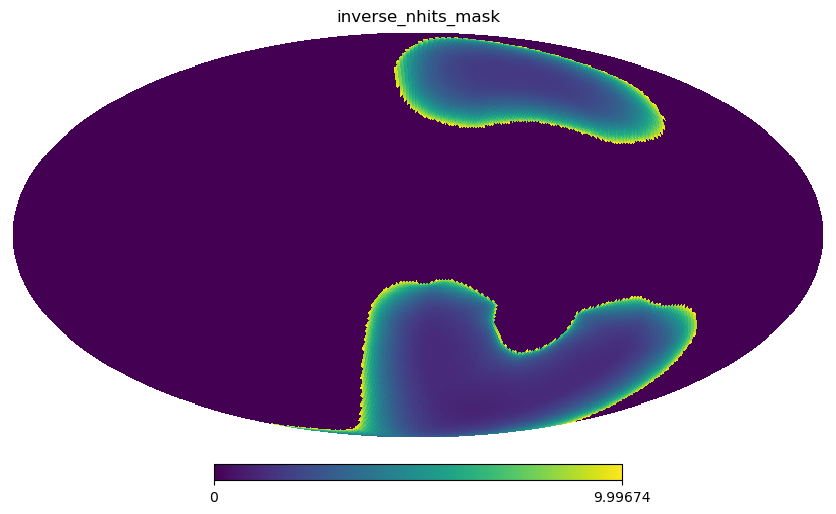

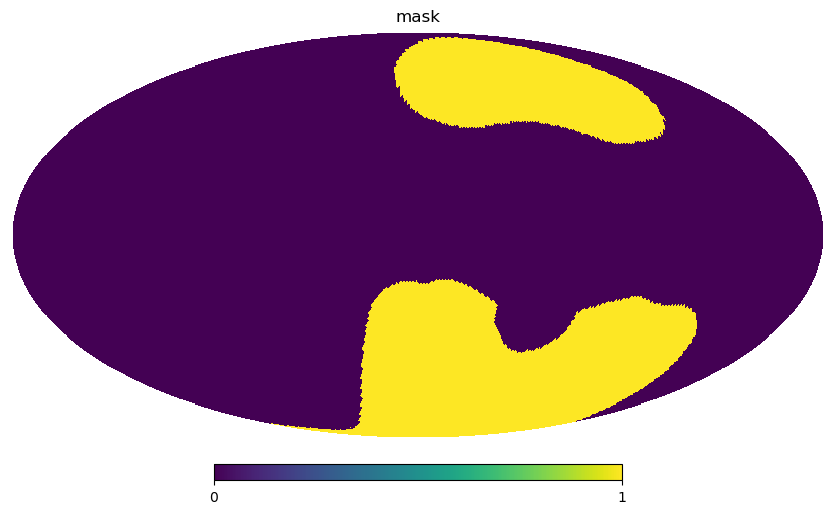

In [10]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

relative_treshold = 1e-1

apod_mask = hp.ud_grade(hp.read_map(path_mask_test),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)

nhits_mask = np.copy(apod_mask)
# nhits_mask = np.copy(mask)
nhits_mask[nhits_mask<relative_treshold] = 0

# nhits_mask[nhits_mask>0] = mask[mask>0]

inverse_nhits_mask = np.copy(nhits_mask)
inverse_nhits_mask[nhits_mask>0] = 1/nhits_mask[nhits_mask>0]

mask[nhits_mask>0] = 1
mask[nhits_mask==0] = 0

hp.mollview(apod_mask, title='apod_mask')
hp.mollview(nhits_mask, title='nhits_mask')
hp.mollview(inverse_nhits_mask, title='inverse_nhits_mask')
hp.mollview(mask, title='mask')


In [11]:
# mask = np.ones(MICMAC_sampler_obj.n_pix)

MICMAC_sampler_obj.mask = jnp.array(mask)

In [12]:
# freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)
freq_inverse_noise_0 = micmac.get_noise_covar(instrument['depth_p'], MICMAC_sampler_obj.nside) #MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_pix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise_0.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_frequencies,nb_pixels_mask), order='C')

freq_inverse_noise_masked = freq_inverse_noise_masked*nhits_mask

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked
freq_inverse_noise = freq_inverse_noise_masked

In [13]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
freq_maps_fgs_noised = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=True)[:, 1:, :]   # keep only Q and U
np.random.seed(noise_seed)
freq_maps_fgs_denoised = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=False)[:, 1:, :]   # keep only Q and U

noise_map = freq_maps_fgs_noised - freq_maps_fgs_denoised
# reweighted_noise_map = noise_map / nhits_mask
reweighted_noise_map = noise_map * jnp.sqrt(inverse_nhits_mask)

freq_maps_fgs = freq_maps_fgs_denoised + reweighted_noise_map

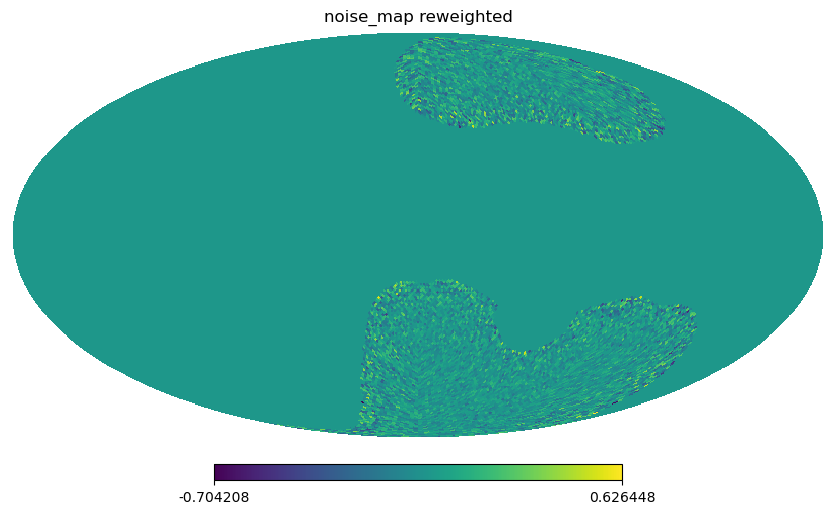

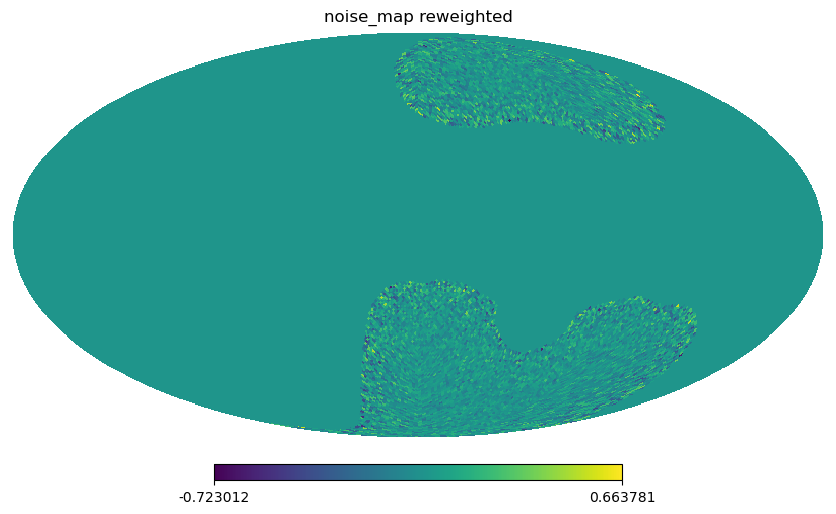

In [14]:
hp.mollview(noise_map[2,0], title='noise_map')
hp.mollview(noise_map[2,1], title='noise_map')
hp.mollview(reweighted_noise_map[2,0], title='noise_map reweighted')
hp.mollview(reweighted_noise_map[2,1], title='noise_map reweighted')

In [15]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [16]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.n_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.n_components, init_params, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)#*mask

BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

nb_pix_mask = int(np.sum(mask))


/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_43489/2248802445.py:6: RuntimeWarning: divide by zero encountered in divide
  hp.mollview(1/BtinvNB[0,0], title='Inverse homogeneous noise CMB')


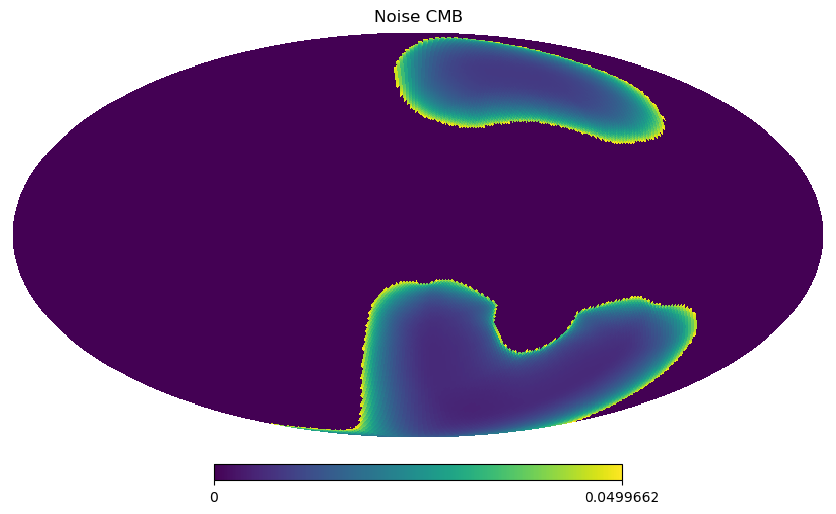

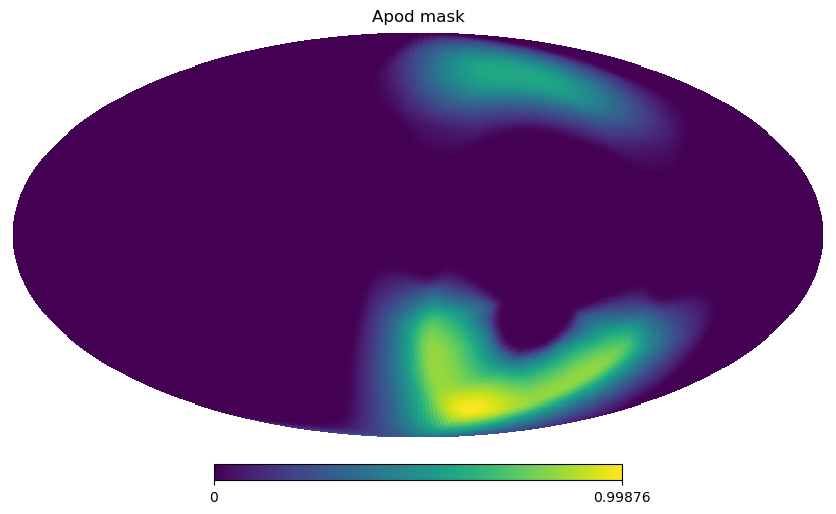

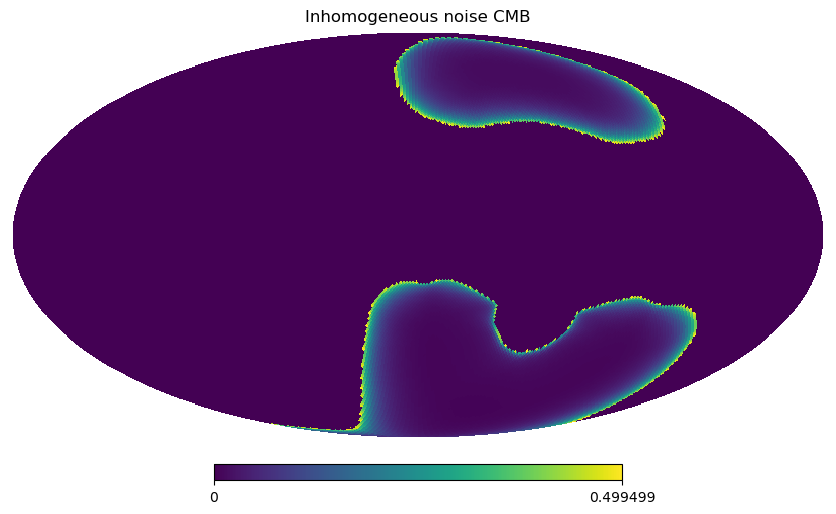

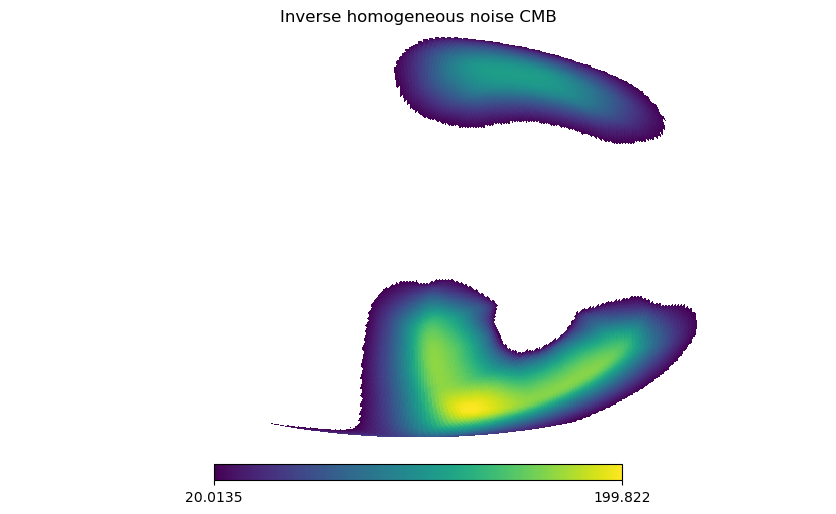

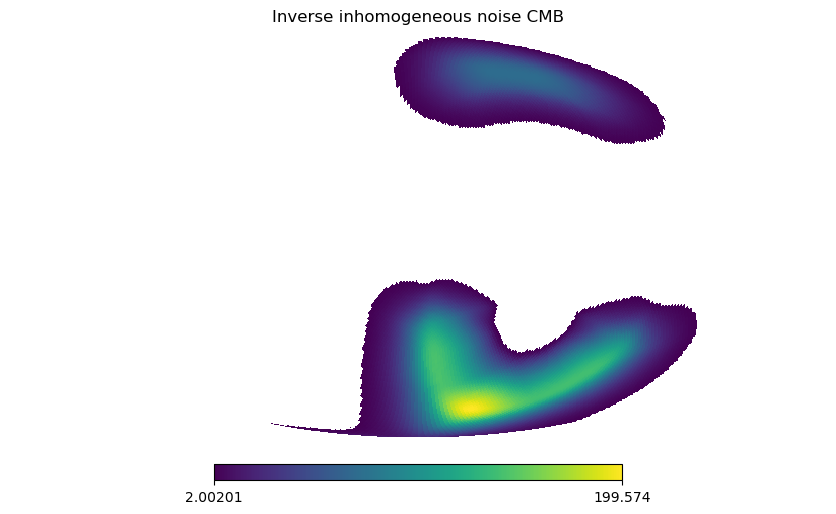

In [17]:
hp.mollview(BtinvNB[0,0], title='Noise CMB')
hp.mollview(apod_mask, title='Apod mask')
inhom_noise = jnp.copy(BtinvNB[0,0])
inhom_noise = inhom_noise.at[apod_mask!=0].set((inhom_noise/apod_mask)[apod_mask!=0])
hp.mollview(inhom_noise, title='Inhomogeneous noise CMB')#, max=1e-2)
hp.mollview(1/BtinvNB[0,0], title='Inverse homogeneous noise CMB')
hp.mollview(1/inhom_noise, title='Inverse inhomogeneous noise CMB')

In [18]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask
input_cmb_maps = input_cmb_maps*mask

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [19]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=False)[0, :, :]

In [20]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [21]:
n_frequencies = MICMAC_sampler_obj.n_frequencies
n_components = MICMAC_sampler_obj.n_components
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter
n_pix = 12*nside**2

In [22]:
MICMAC_sampler_obj.tolerance_CG = 1e-6
# MICMAC_sampler_obj.limit_iter_cg = 2000

In [23]:
%%time
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = None
map_random_realization_chi = None
fluctuation_maps_v2c = MICMAC_sampler_obj.get_fluctuating_term_maps_v2c(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey, 
                                                                        map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, 
                                                                        initial_guess=jnp.empty(0))


Recalculating xi !
Recalculating chi !
CG Fluct finished in  10.60972809791565 seconds !!
CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 1min 4s, sys: 7.59 s, total: 1min 11s
Wall time: 14 s


In [24]:
jitted_get_fluctuating_term_maps_v2c = jax.jit(MICMAC_sampler_obj.get_fluctuating_term_maps_v2c)

In [25]:
# %%time
# PRNGKey = random.PRNGKey(0)
# map_random_realization_xi = None
# map_random_realization_chi = None
# # fluctuation_maps_v2 = get_fluctuating_term_maps_v2(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
# fluctuation_maps_v2c = jitted_get_fluctuating_term_maps_v2c(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey, 
#                                                                         map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, 
#                                                                         initial_guess=jnp.empty(0))
# # fluctuation_maps_v2 = get_fluctuating_term_maps_v2(MICMAC_sampler_obj, red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))


In [26]:
%%time
wiener_filter_term_v2c = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2c(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 56.1 s, sys: 6.98 s, total: 1min 3s
Wall time: 11.6 s


In [27]:
jitted_solve_generalized_wiener_filter_term_v2c = jax.jit(MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2c)

In [28]:
# %%time
# wiener_filter_term_v2c = jitted_solve_generalized_wiener_filter_term_v2c(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


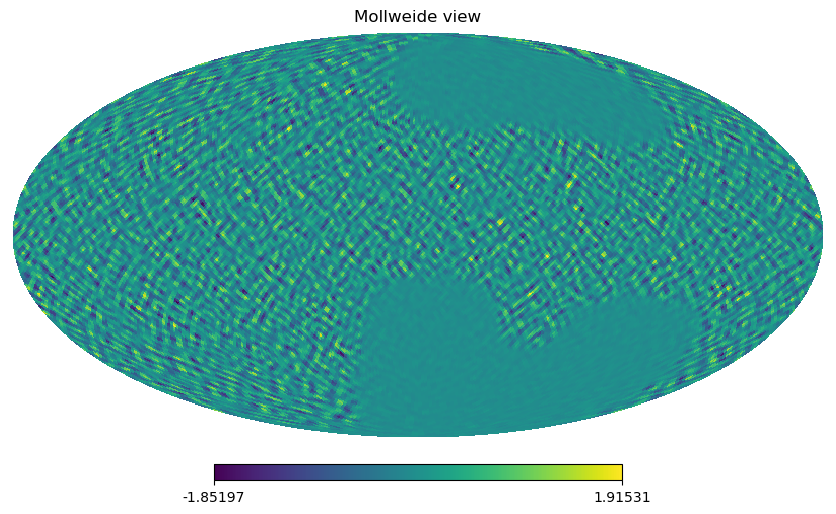

In [29]:
hp.mollview(fluctuation_maps_v2c[0])
hp.mollview(fluctuation_maps_v2c[1])

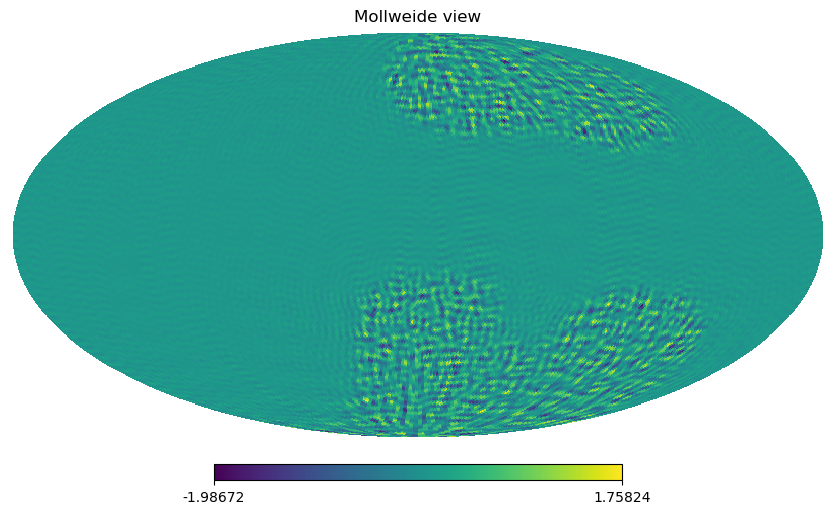

In [30]:
hp.mollview(wiener_filter_term_v2c[0])
hp.mollview(wiener_filter_term_v2c[1])

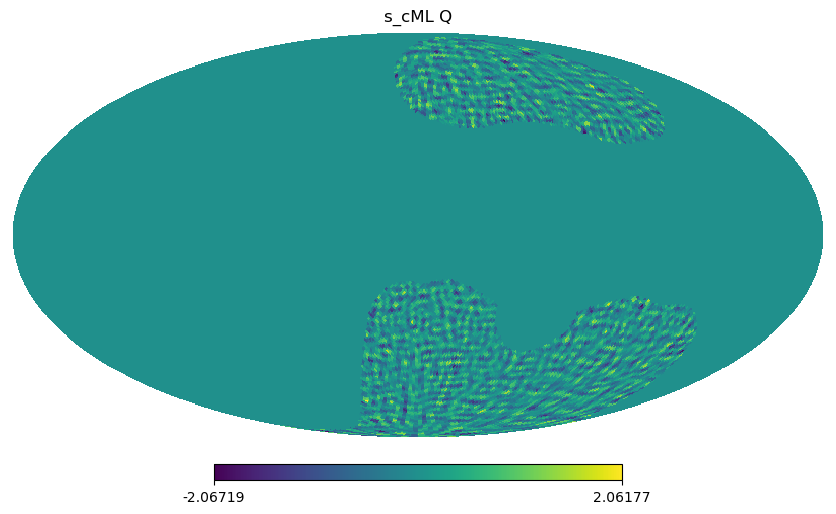

In [31]:
hp.mollview(s_cML[0], title='s_cML Q')
hp.mollview(s_cML[1], title='s_cML U')

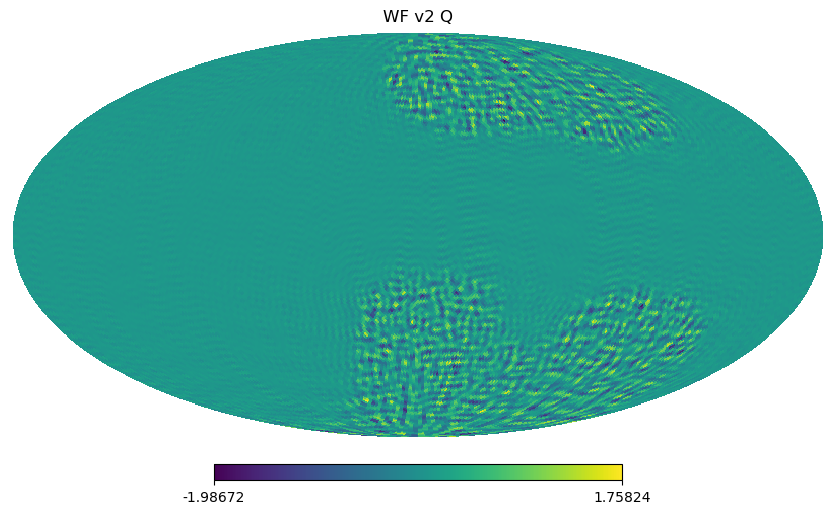

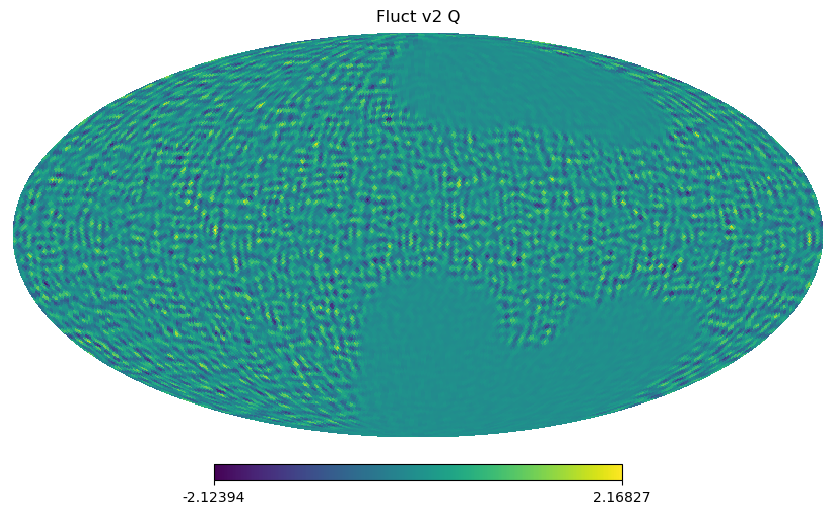

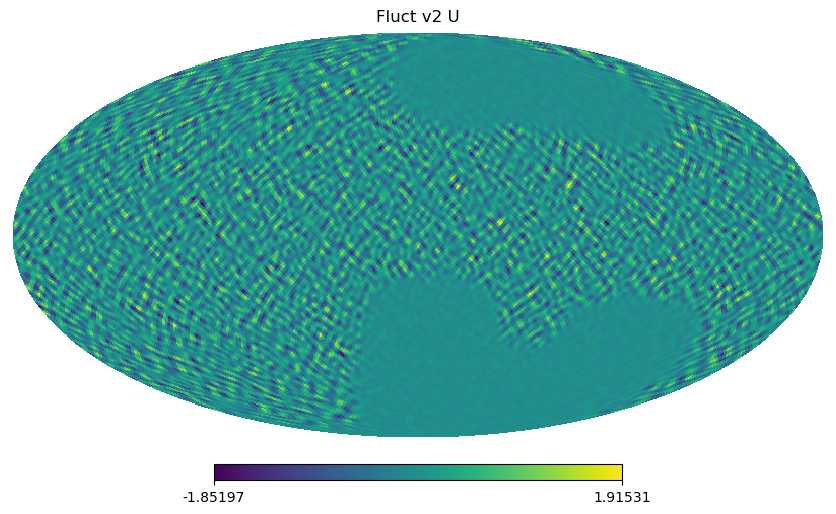

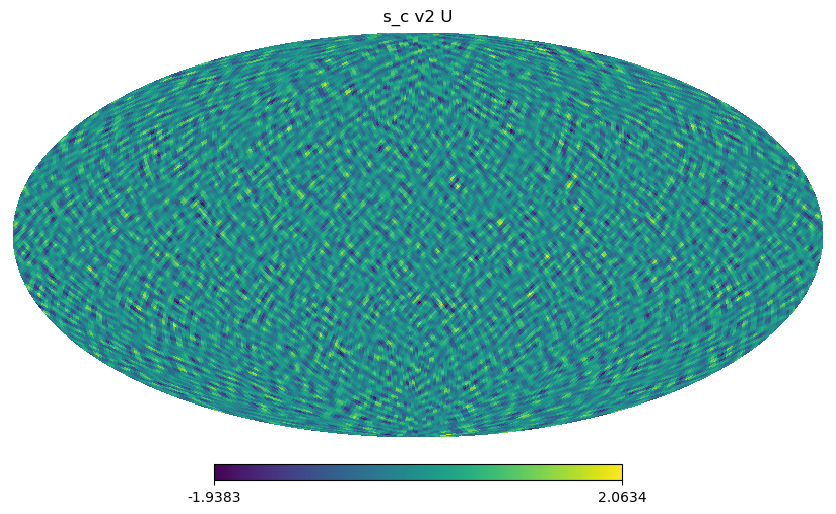

In [32]:
hp.mollview(wiener_filter_term_v2c[0], title='WF v2 Q')
hp.mollview(wiener_filter_term_v2c[1], title='WF v2 U')

hp.mollview(fluctuation_maps_v2c[0], title='Fluct v2 Q')
hp.mollview(fluctuation_maps_v2c[1], title='Fluct v2 U')

hp.mollview((wiener_filter_term_v2c+fluctuation_maps_v2c)[0], title='s_c v2 Q')
hp.mollview((wiener_filter_term_v2c+fluctuation_maps_v2c)[1], title='s_c v2 U')

In [33]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [34]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

In [35]:
fsky = mask.sum()/mask.size
fsky = 1#mask.sum()/mask.size

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


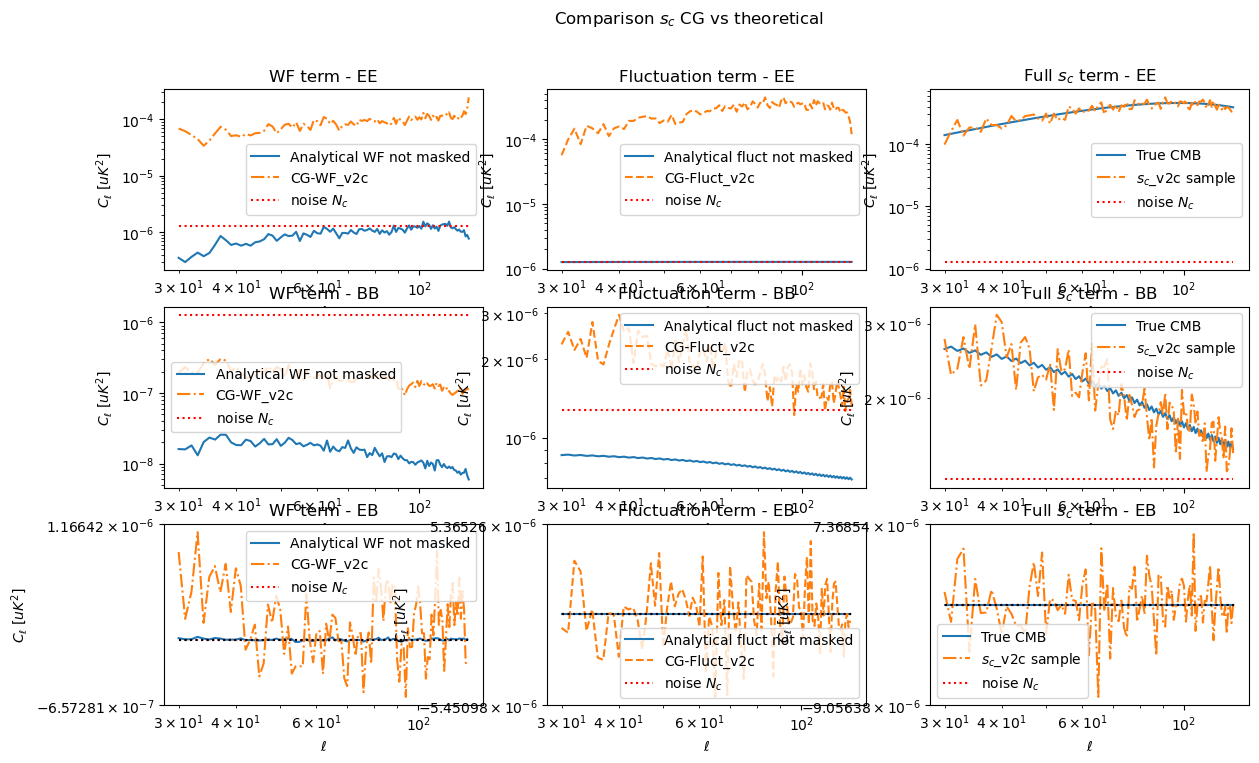

In [36]:
list_correl = ['EE', 'BB', 'EB']

c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
#                                                                         analytical_WF_harm, lmin=lmin, n_iter=n_iter)

s_cML_unmasked = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML_unmasked/BtinvNB[0,0,mask!=0][0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]


s_c_WF_v2c_maps_extended = np.vstack([np.zeros_like(wiener_filter_term_v2c[0,...]), wiener_filter_term_v2c])
c_ells_s_c_WF_v2c = hp.anafast(s_c_WF_v2c_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_v2c_maps_extended = np.vstack([np.zeros_like(fluctuation_maps_v2c[0,...]), fluctuation_maps_v2c])
c_ells_s_c_fluct_v2c = hp.anafast(s_c_fluct_v2c_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_sample_v2c = wiener_filter_term_v2c + fluctuation_maps_v2c
s_c_v2c_recovered_ext = np.vstack([np.zeros_like(s_c_sample_v2c[0]),s_c_sample_v2c])
c_ells_s_c_v2c = hp.anafast(s_c_v2c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF_v2c.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF not masked')
    plt.plot(np.arange(c_ells_s_c_WF_v2c.shape[-1])+lmin, c_ells_s_c_WF_v2c[j,:]/fsky, '-.', label='CG-WF_v2c')
    plt.plot(np.arange(c_ells_s_c_WF_v2c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct_v2c.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct not masked')
    plt.plot(np.arange(c_ells_s_c_fluct_v2c.shape[-1])+lmin, c_ells_s_c_fluct_v2c[j,:]/fsky, '--', label='CG-Fluct_v2c')
    plt.plot(np.arange(c_ells_s_c_fluct_v2c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_v2c.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_v2c.shape[-1])+lmin, c_ells_s_c_v2c[j,:]/fsky, '-.', label='$s_c$_v2c sample')
    plt.plot(np.arange(c_ells_s_c_v2c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()